In [2]:
!pip install tqdm xgboost seaborn

import os, time
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support #, roc_curve, roc_auc_score, recall_score, precision_score,
from sklearn.preprocessing import LabelEncoder#, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier #, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
# from umap import UMAP

from xgboost import XGBClassifier

# from helpers import get_ip_address, has_write_permission, measure_performance

import warnings
warnings.filterwarnings("ignore") # 경고 메시지 무시

import logging


In [12]:
# Set up logging
logger = logging.getLogger()  # Get the root logger
logger.setLevel(logging.INFO)  # Set the minimum logging level

log_file_handler = logging.FileHandler('logs.txt')
log_file_handler.setLevel(logging.INFO)  # Set the logging level for the file
log_file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(log_file_handler)

log_console_handler = logging.StreamHandler()
log_console_handler.setLevel(logging.INFO)
log_console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(log_console_handler)

RANDOM_SEED = 42
RANDOM_SEED_DATASET = 42

class data_loader:
    def __init__(self, X_path, sample_annotation_file):
        super().__init__()
        
        self.target_label_name ='Population code'
        self.notusing_lables = ['IBS,MSL', 'GBR', 'ASW', 'ACB', 'GIH', 'CHB', 'STU', 'ITU']
        data_split = [0.6, 0.2, 0.2] # train, val, test

        self.X = np.load(X_path)
        self.sample_annotation_df = pd.read_csv(sample_annotation_file, sep='\t')
        self.y = self.sample_annotation_df[self.target_label_name]
        logging.info(f"[progress] Read data done. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

        self.drop_notusing_sample(notusing_list= self.notusing_lables)
        self.y_encoded, self.label_mapping = self.encode_y()
        self.train_indices, self.val_indices, self.test_indices = self.split_dataset(val_size = data_split[1], test_size = data_split[2])

        logging.info(f" - Data_split: train_set (n= {len(self.train_indices)}), val_set (n= {len(self.val_indices)}), test_set (n= {len(self.test_indices)})")
        assert self.X.shape[0] == self.y.shape[0]
        assert self.X.shape[0] == self.y_encoded.shape[0]
        assert self.test_index_coverage(self.train_indices, self.val_indices, self.test_indices, self.X.shape[0])


    def test_index_coverage(self, train_indices, val_indices, test_indices, total_length):
        combined_indices = np.concatenate((train_indices, val_indices, test_indices))
        unique_indices = np.unique(combined_indices)
        expected_indices = np.arange(total_length)
        if np.array_equal(np.sort(unique_indices), expected_indices):
            return True
        else:
            missing_indices = np.setdiff1d(expected_indices, unique_indices)
            extra_indices = np.setdiff1d(unique_indices, expected_indices)
            print(f"Missing indices: {missing_indices}")
            print(f"Extra indices: {extra_indices}")
            return False

    def drop_notusing_sample(self, notusing_list):
        indices_to_drop = self.sample_annotation_df[self.sample_annotation_df[self.target_label_name].isin(notusing_list)].index
        if not indices_to_drop.empty:
            self.sample_annotation_df = self.sample_annotation_df.drop(indices_to_drop)
            self.y = self.y.drop(indices_to_drop)
            self.X = np.delete(self.X, indices_to_drop, axis=0)
        logging.info(f"[progress] Dropped {len(indices_to_drop)} samples from the dataset. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

    def encode_y(self):
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(self.y)
        label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
        return y_encoded, label_mapping

    def split_dataset(self, val_size=0.15, test_size=0.15):
        sss = StratifiedShuffleSplit(n_splits=1, test_size = test_size, random_state = RANDOM_SEED)
        train_val_idx, test_indices = next(sss.split(self.X, self.y_encoded))
        adjusted_val_size = val_size / (1 - test_size)
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_val_size, random_state=RANDOM_SEED)
        train_idx, val_idx = next(sss_val.split(self.X[train_val_idx], self.y_encoded[train_val_idx]))
        train_indices = train_val_idx[train_idx]
        val_indices = train_val_idx[val_idx]
        return train_indices, val_indices, test_indices

    def get_data(self):
        return (self.X, np.array(self.y), self.y_encoded), (self.train_indices, self.val_indices, self.test_indices), self.label_mapping

In [14]:
feature_data_path = '/project/datacamp/team11/data' 
# target_feature = "preprocessed/merged_support3_variance_0.1_random_1M"
target_feature = "preprocessed/merged_random_1k" 
target_feature_suffix = "_matrix.npy"
sample_annotation_file = os.path.join(feature_data_path, "igsr-1000 genomes 30x on grch38.tsv")

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                      sample_annotation_file)
(X, y_original, y), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


2024-05-16 03:26:30,988 - INFO - [progress] Read data done. X.shape: (3202, 1000), y.shape: (3202,)
2024-05-16 03:26:30,990 - INFO - [progress] Dropped 709 samples from the dataset. X.shape: (2493, 1000), y.shape: (2493,)
2024-05-16 03:26:30,992 - INFO -  - Data_split: train_set (n= 1495), val_set (n= 499), test_set (n= 499)


BEB: 데이터 개수 = 131, 클래스 다양성 = 1
CDX: 데이터 개수 = 93, 클래스 다양성 = 1
CEU: 데이터 개수 = 179, 클래스 다양성 = 1
CHS: 데이터 개수 = 163, 클래스 다양성 = 1
CLM: 데이터 개수 = 132, 클래스 다양성 = 1
ESN: 데이터 개수 = 149, 클래스 다양성 = 1
FIN: 데이터 개수 = 99, 클래스 다양성 = 1
GWD: 데이터 개수 = 178, 클래스 다양성 = 1
IBS: 데이터 개수 = 156, 클래스 다양성 = 1
JPT: 데이터 개수 = 104, 클래스 다양성 = 1
KHV: 데이터 개수 = 122, 클래스 다양성 = 1
LWK: 데이터 개수 = 99, 클래스 다양성 = 1
MSL: 데이터 개수 = 99, 클래스 다양성 = 1
MXL: 데이터 개수 = 97, 클래스 다양성 = 1
PEL: 데이터 개수 = 122, 클래스 다양성 = 1
PJL: 데이터 개수 = 146, 클래스 다양성 = 1
PUR: 데이터 개수 = 139, 클래스 다양성 = 1
TSI: 데이터 개수 = 107, 클래스 다양성 = 1
YRI: 데이터 개수 = 178, 클래스 다양성 = 1


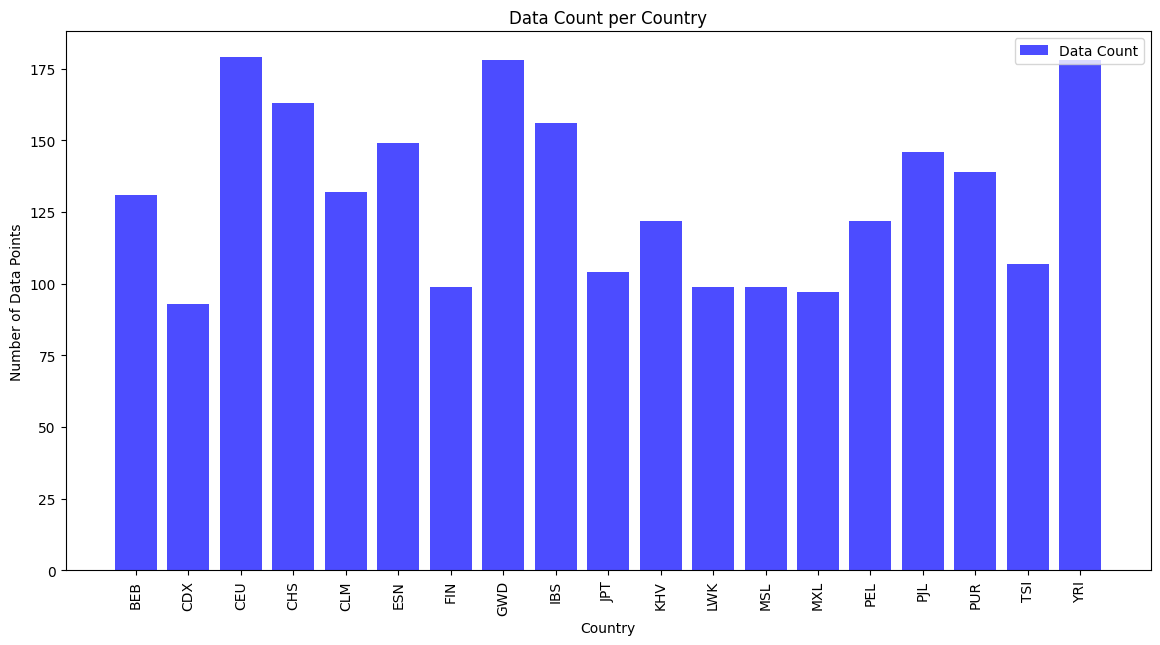

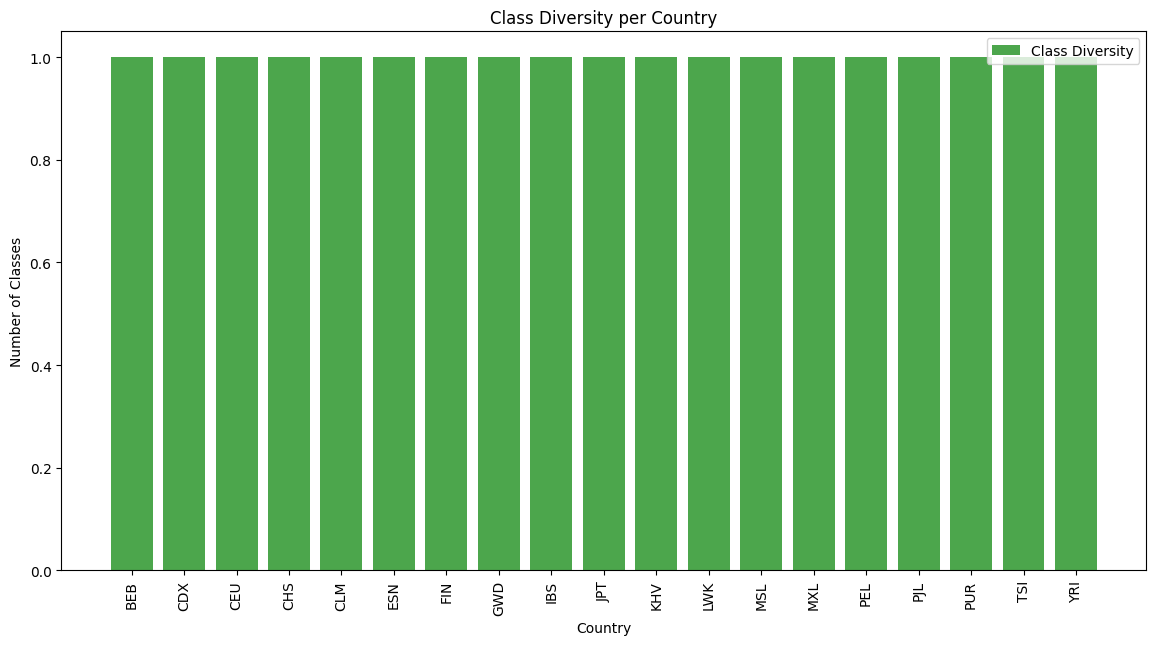

In [17]:
# label check
y_labels = np.array([label_mapping[label] for label in y])
unique_countries = np.unique(y_labels)

# Data Count per Country and Class Diversity Visualization 
country_data_count = []
country_class_diversity = []

for country in unique_countries:
    indices = np.where(y_labels == country)[0]
    classes = np.unique(y[indices])
    country_data_count.append(len(indices))
    country_class_diversity.append(len(classes))

    print(f"{country}: 데이터 개수 = {len(indices)}, 클래스 다양성 = {len(classes)}")

# Visualzation
plt.figure(figsize=(14, 7))
plt.bar(unique_countries, country_data_count, color='blue', alpha=0.7, label='Data Count')
plt.title('Data Count per Country')
plt.xlabel('Country')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14, 7))
plt.bar(unique_countries, country_class_diversity, color='green', alpha=0.7, label='Class Diversity')
plt.title('Class Diversity per Country')
plt.xlabel('Country')
plt.ylabel('Number of Classes')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

In [10]:
y_labels = np.array([label_mapping[label] for label in y])

X_train, X_test, y_train, y_test, y_labels_train, y_labels_test = train_test_split(X, y, y_labels, test_size=0.2, random_state=RANDOM_SEED)
# params = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']} 
params = {'C': [0.00001, 0.0001], 'kernel': 'linear'}
model = SVC(**params, random_state=RANDOM_SEED)
model.fit(X_train, y_train)
# {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']} 

y_pred = model.predict(X_test)
overall_accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Overall Accuracy: {overall_accuracy:.2f}%")

unique_countries = np.unique(y_labels)
country_data_count = []
country_accuracies = []

for country in unique_countries:
    country_indices = np.where(y_labels == country)[0]
    test_indices = np.where(y_labels_test == country)[0]
    X_country = X_test[test_indices]
    y_country = y_test[test_indices]
    y_pred_country = y_pred[test_indices]
    
    country_data_count.append(len(country_indices))
    
    if len(y_country) > 0:
        accuracy = accuracy_score(y_country, y_pred_country) * 100
        country_accuracies.append(accuracy)
    else:
        country_accuracies.append(np.nan)

Overall Accuracy: 98.80%


# Visualization

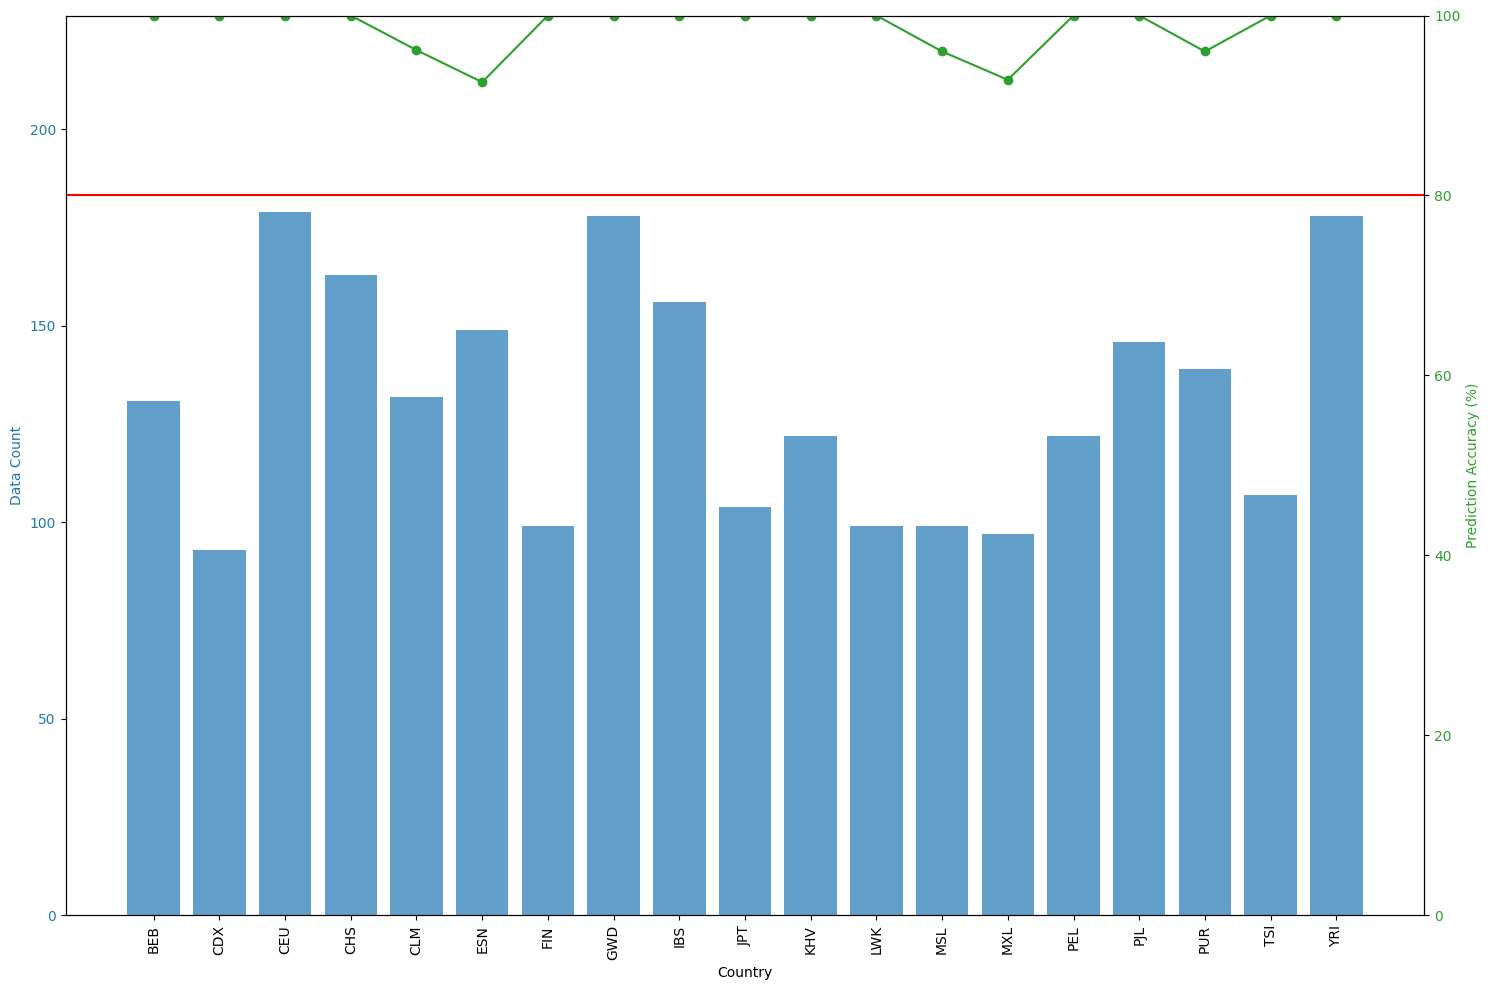

In [11]:

def plot_country_data_and_accuracies(countries, data_count, accuracies, file_path=None):
    fig, ax1 = plt.subplots(figsize=(15, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Country')
    ax1.set_ylabel('Data Count', color=color)
    ax1.bar(countries, data_count, color=color, alpha=0.7, label='Data Count')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, max(data_count) + 50)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  
    color = 'tab:green'
    ax2.set_ylabel('Prediction Accuracy (%)', color=color)
    ax2.plot(countries, accuracies, color=color, marker='o', label='Prediction Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)
    ax2.axhline(y=80, color='r', linestyle='-')

    fig.tight_layout()  
    if file_path:
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_country_data_and_accuracies(unique_countries, country_data_count, country_accuracies, file_path="country_data_and_accuracy.png")